In [3]:
!pip install mlxtend

In [4]:
# 데이터 처리와 수치 계산을 위한 라이브러리
import pandas as pd
import numpy as np

# 로지스틱 회귀 모델과 학습/검증 데이터 분할 도구
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 데이터 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

# 순차적 특징 선택(Sequential Feature Selection)을 위한 외부 라이브러리 mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# 분류용 샘플 데이터 생성, 랜덤 포레스트 분류기
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# 반복적 특징 제거 + 교차 검증을 통한 최적 특징 선택 (RFECV)
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# 아이리스 데이터셋 로드, 로지스틱 회귀, RFE (Recursive Feature Elimination)
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE


from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [5]:
titanic = sns.load_dataset('titanic')
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [6]:
# 'age'와 'embarked' 컬럼에 결측치가 있는 행을 삭제
titanic.dropna(subset=['age','embarked'], inplace=True)

In [7]:
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Q,Third,woman,False,NaN,Queenstown,no,False
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [8]:
# 'sex', 'embarked', 'class' 범주형 변수들을 원-핫 인코딩하고 첫 번째 범주는 제거하여 다중공선성 방지
titanic = pd.get_dummies(titanic, columns=['sex', 'embarked', 'class'], drop_first=True)

In [9]:
# 분석 대상에서 제외할 변수들을 제거하여 입력 변수 X 구성
X = titanic.drop(['survived', 'deck', 'alone', 'who', 'adult_male', 'alive', 'embark_town'], axis=1)

In [10]:
# 데이터프레임 X의 값을 숫자형으로 강제 변환 (True/False → 1/0, object → numeric)
X = X * 1

# 목표 변수 y 정의 ('survived' 컬럼: 생존 여부 0 = 사망, 1 = 생존)
y = titanic['survived']

In [11]:
# 학습용(train)과 테스트용(test) 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

In [12]:
## Wrapper 방식: 모델을 활용해 반복적으로 성능을 평가하면서 중요한 변수를 선택하는 방식

# 로지스틱 회귀 모델 정의 (최대 반복 횟수를 1000으로 설정해 수렴 안정성 향상)
model = LogisticRegression(max_iter=1000)

In [13]:
## Sequential Feature Selector(SFS)를 사용한 변수 선택 전략 정의

# 1. Forward Selection: 변수를 하나씩 추가하며 성능이 향상되는 조합을 선택
sfs_forward = SFS(model, 
                  k_features='best',        # 최적의 feature 개수를 자동 선택
                  forward=True,             # Forward 방식 (추가만 함)
                  floating=False,           # Floating 비활성화
                  scoring='accuracy',       # 평가 지표는 정확도
                  cv=3)                     # 3-폴드 교차검증

# 2. Backward Elimination: 전체 변수에서 하나씩 제거하면서 성능을 평가
sfs_backward = SFS(model, 
                   k_features='best',
                   forward=False,           # Backward 방식 (제거만 함)
                   floating=False,
                   scoring='accuracy',
                   cv=3)

# 3. Stepwise Selection: Forward 방식에 floating을 켜서 유연하게 추가/제거 가능
sfs_stepwise = SFS(model, 
                   k_features='best',
                   forward=True,            # Forward 기반
                   floating=True,           # Floating 활성화 (추가 후 필요하면 제거)
                   scoring='accuracy',
                   cv=3)

In [14]:
## 모델을 학습용 데이터에 맞춰 변수 선택 수행

# Forward 방식으로 선택한 모델 학습
sfs_forward_m = sfs_forward.fit(X_train, y_train)

# Backward 방식으로 선택한 모델 학습
sfs_backward_m = sfs_backward.fit(X_train, y_train)

# Stepwise 방식으로 선택한 모델 학습
sfs_stepwise_m = sfs_stepwise.fit(X_train, y_train)

In [15]:
## 선택된 피처들을 출력해서 살펴보기
## k_feature_names_ 데이터를 살펴볼 수 있다.


print(sfs_forward_m.k_feature_names_,'forward')
print(sfs_backward_m.k_feature_names_,'backward')
print(sfs_stepwise_m.k_feature_names_,'stepwise')

('pclass', 'age', 'sibsp', 'sex_male', 'embarked_S') forward
('pclass', 'age', 'sibsp', 'sex_male', 'embarked_S') backward
('pclass', 'age', 'sibsp', 'sex_male', 'embarked_S') stepwise


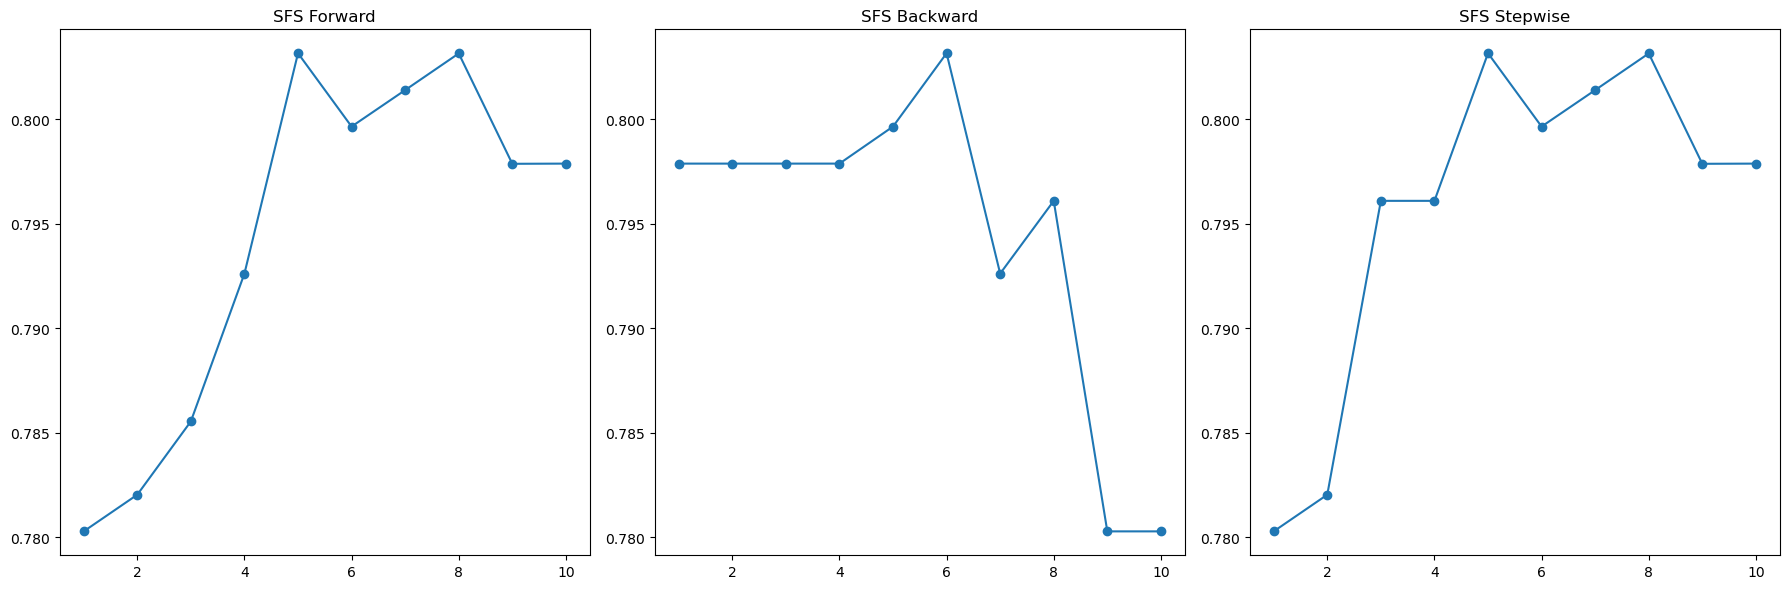

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Forward Selection
ax[0].plot(
    range(1, len(sfs_forward_m.subsets_) + 1),
    [sfs_forward_m.subsets_[i]['avg_score'] for i in sfs_forward_m.subsets_],
    marker='o'
)
ax[0].set_title('SFS Forward')

# Backward Elimination
ax[1].plot(
    range(1, len(sfs_backward_m.subsets_) + 1),
    [sfs_backward_m.subsets_[i]['avg_score'] for i in sfs_backward_m.subsets_],
    marker='o'
)
ax[1].set_title('SFS Backward')

# Stepwise
ax[2].plot(
    range(1, len(sfs_stepwise_m.subsets_) + 1),
    [sfs_stepwise_m.subsets_[i]['avg_score'] for i in sfs_stepwise_m.subsets_],
    marker='o'
)
ax[2].set_title('SFS Stepwise')

plt.tight_layout()
plt.show()

In [17]:
sfs_forward_m.subsets_
#피처 선택 과정을 기록한 핵심 속성

{1: {'feature_idx': (5,),
  'cv_scores': array([0.78947368, 0.79473684, 0.75661376]),
  'avg_score': 0.7802747609765154,
  'feature_names': ('sex_male',)},
 2: {'feature_idx': (2, 5),
  'cv_scores': array([0.79473684, 0.79473684, 0.75661376]),
  'avg_score': 0.7820291469414277,
  'feature_names': ('sibsp', 'sex_male')},
 3: {'feature_idx': (0, 2, 5),
  'cv_scores': array([0.8       , 0.8       , 0.75661376]),
  'avg_score': 0.7855379188712522,
  'feature_names': ('pclass', 'sibsp', 'sex_male')},
 4: {'feature_idx': (0, 1, 2, 5),
  'cv_scores': array([0.78947368, 0.8       , 0.78835979]),
  'avg_score': 0.7926111575234382,
  'feature_names': ('pclass', 'age', 'sibsp', 'sex_male')},
 5: {'feature_idx': (0, 1, 2, 5, 7),
  'cv_scores': array([0.8       , 0.81052632, 0.7989418 ]),
  'avg_score': 0.8031560382437576,
  'feature_names': ('pclass', 'age', 'sibsp', 'sex_male', 'embarked_S')},
 6: {'feature_idx': (0, 1, 2, 5, 6, 7),
  'cv_scores': array([0.79473684, 0.80526316, 0.7989418 ]),
  'a

In [18]:
sfs_backward_m.subsets_

{10: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
  'cv_scores': array([0.79473684, 0.81052632, 0.78835979]),
  'avg_score': 0.797874315418175,
  'feature_names': ('pclass',
   'age',
   'sibsp',
   'parch',
   'fare',
   'sex_male',
   'embarked_Q',
   'embarked_S',
   'class_Second',
   'class_Third')},
 9: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8),
  'cv_scores': array([0.79473684, 0.81052632, 0.78835979]),
  'avg_score': 0.797874315418175,
  'feature_names': ('pclass',
   'age',
   'sibsp',
   'parch',
   'fare',
   'sex_male',
   'embarked_Q',
   'embarked_S',
   'class_Second')},
 8: {'feature_idx': (0, 1, 2, 3, 5, 6, 7, 8),
  'cv_scores': array([0.8       , 0.80526316, 0.78835979]),
  'avg_score': 0.797874315418175,
  'feature_names': ('pclass',
   'age',
   'sibsp',
   'parch',
   'sex_male',
   'embarked_Q',
   'embarked_S',
   'class_Second')},
 7: {'feature_idx': (0, 1, 2, 3, 5, 6, 7),
  'cv_scores': array([0.79473684, 0.81052632, 0.78835979]),
  'avg_score': 0.79787431

In [19]:
sfs_stepwise_m.subsets_

{1: {'feature_idx': (5,),
  'cv_scores': array([0.78947368, 0.79473684, 0.75661376]),
  'avg_score': 0.7802747609765154,
  'feature_names': ('sex_male',)},
 2: {'feature_idx': (2, 5),
  'cv_scores': array([0.79473684, 0.79473684, 0.75661376]),
  'avg_score': 0.7820291469414277,
  'feature_names': ('sibsp', 'sex_male')},
 3: {'feature_idx': (0, 1, 5),
  'cv_scores': array([0.81052632, 0.80526316, 0.77248677]),
  'avg_score': 0.7960920820569943,
  'feature_names': ('pclass', 'age', 'sex_male')},
 4: {'feature_idx': (0, 1, 5, 6),
  'cv_scores': array([0.81052632, 0.80526316, 0.77248677]),
  'avg_score': 0.7960920820569943,
  'feature_names': ('pclass', 'age', 'sex_male', 'embarked_Q')},
 5: {'feature_idx': (0, 1, 2, 5, 7),
  'cv_scores': array([0.8       , 0.81052632, 0.7989418 ]),
  'avg_score': 0.8031560382437576,
  'feature_names': ('pclass', 'age', 'sibsp', 'sex_male', 'embarked_S')},
 6: {'feature_idx': (0, 1, 2, 5, 6, 7),
  'cv_scores': array([0.79473684, 0.80526316, 0.7989418 ]),
 

# RFE
모델 기반으로 각 피처의 중요도를 평가하고, 가장 중요도가 낮은 피처를 하나씩 제거해나감.
전체 피처로 모델 훈련 - 가장 덜 중요한 피처 제거 - 다시 모델 훈련 - 반복해서 원하는 피처 수만큼 남기기

In [20]:
# Iris 데이터셋에서 입력 변수(X)와 타겟(y)만 따로 로드
X, y = load_iris(return_X_y=True)

In [21]:
# 로지스틱 회귀 모델 정의 (반복 횟수 200으로 설정)
model = LogisticRegression(max_iter=200)

# RFE(Recursive Feature Elimination) 설정: 가장 중요한 변수 2개 선택
selector = RFE(estimator=model, n_features_to_select=2)

# RFE를 사용하여 특징 선택 수행
selector = selector.fit(X, y)

In [22]:
## selector.support_  각 피처(컬럼)가 선택되었는지 여부
selector.support_

array([False, False,  True,  True])

In [23]:
selector.ranking_  #각 피처에 대한 순위

array([3, 2, 1, 1])

In [24]:
## 선택된 최적의 수는 몇 개인가?
selector.n_features_

2

In [25]:
#RFECV

In [26]:
# 랜덤포레스트 모델 정의
model = RandomForestClassifier()

# Stratified K-Fold 설정 (클래스 비율 유지)
cv = StratifiedKFold(n_splits=3)

# RFECV로 최적 피처 자동 선택
selector = RFECV(estimator=model, step=1, cv=cv)
selector = selector.fit(X, y)

In [27]:
# 선택된 피처 마스크 출력 (True = 선택됨, False = 제거됨)
print(selector.support_)

[False False  True  True]


In [28]:
#각 피처의 중요도 순위
print(selector.ranking_)

[2 3 1 1]


In [38]:
pip install ucimlrepo

In [37]:
# ucimlrepo에서 fetch_ucirepo 함수 임포트
from ucimlrepo import fetch_ucirepo

# 1. UCI Spambase 데이터셋 불러오기 (id=94는 Spambase의 고유 ID)
spambase = fetch_ucirepo(id=94)

# 2. X: 입력 변수, y: 타겟 변수 (스팸 여부)
X = spambase.data.features      # pandas DataFrame 형식
y = spambase.data.targets.values.ravel()       # 일반적으로 0 = 비스팸, 1 = 스팸

# 3. 데이터셋 메타정보 출력 (설명, 출처, 태그 등)
print(spambase.metadata)

# 4. 각 변수(컬럼)의 의미 및 타입 정보
print(spambase.variables)

{'uci_id': 94, 'name': 'Spambase', 'repository_url': 'https://archive.ics.uci.edu/dataset/94/spambase', 'data_url': 'https://archive.ics.uci.edu/static/public/94/data.csv', 'abstract': 'Classifying Email as Spam or Non-Spam', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 4601, 'num_features': 57, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1999, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C53G6X', 'creators': ['Mark Hopkins', 'Erik Reeber', 'George Forman', 'Jaap Suermondt'], 'intro_paper': None, 'additional_info': {'summary': 'The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography...\n\nThe classification task for this dataset is to determine whether a given email is spam or not.\n\t\nOur collecti

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

# 가장 최적의 모델링 성과

In [43]:
# 모델별 성능 평가

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({'Model': name, 'Accuracy': acc, 'F1-Score': f1})

results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)
print(results_df)

                Model  Accuracy  F1-Score
1        RandomForest  0.946797  0.930889
0  LogisticRegression  0.929425  0.909344
2                 SVM  0.927253  0.905501
3                 KNN  0.905537  0.878999


In [44]:
# 최적 모델 
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

# 최적의 모델을 통해서 피처 셀렉션

In [46]:
# SFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs = SFS(model, k_features='best', forward=True, floating=False, scoring='accuracy', cv=3)
sfs.fit(X_train, y_train)
sfs_features = list(X.columns[list(sfs.k_feature_idx_)])

In [47]:
print("sfs_features:", sfs_features)

sfs_features: ['word_freq_make', 'word_freq_address', 'word_freq_3d', 'word_freq_our', 'word_freq_remove', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_report', 'word_freq_free', 'word_freq_business', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_[', 'char_freq_!', 'char_freq_$', 'capital_run_length_average', 'capital_run_length_longest']


In [48]:
# RFECV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
rfecv = RFECV(estimator=model, cv=StratifiedKFold(3), scoring='accuracy')
rfecv.fit(X_train, y_train)
rfecv_features = list(X.columns[rfecv.support_])

In [49]:
print("RFECV Features:", rfecv_features)

RFECV Features: ['word_freq_make', 'word_freq_address', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_will', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_!', 'char_freq_$', 'char_freq_#', 'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total']


In [50]:
# 원본 X를 DataFrame으로 유지
X = spambase.data.features
y = spambase.data.targets.values.ravel()

# 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# 여기서만 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# filter method는 X_train 원본으로 사용
correlations = X_train.corrwith(pd.Series(y_train)).abs().sort_values(ascending=False)
filter_features = correlations.head(10).index.tolist()

In [51]:
print("Filter Features:", filter_features)

Filter Features: ['word_freq_3d', 'word_freq_hpl', 'word_freq_receive', 'word_freq_hp', 'word_freq_pm', 'word_freq_free', 'word_freq_email', 'word_freq_your', 'word_freq_addresses', 'capital_run_length_total']


# filter vs Wrapper 성능 비교

In [ ]:
# 1. 데이터 로드 및 전처리
spambase = fetch_ucirepo(id=94)
X = spambase.data.features
y = spambase.data.targets.values.ravel()

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 표준화 (Wrapper 방식용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 최적 모델 = RandomForest
model = RandomForestClassifier(random_state=42)

# Filter 방식 
# 상관계수 기반 상위 10개 피처 선택
correlations = X_train.corrwith(pd.Series(y_train)).abs().sort_values(ascending=False)
filter_features = correlations.head(10).index.tolist()

# 선택된 피처로 모델 학습 및 평가
model_filter = RandomForestClassifier(random_state=42)
model_filter.fit(X_train[filter_features], y_train)
y_pred_filter = model_filter.predict(X_test[filter_features])
f1_filter = f1_score(y_test, y_pred_filter)

# Wrapper 방식 (SFS)
sfs = SFS(model, k_features=10, forward=True, floating=False, scoring='f1', cv=3)
sfs.fit(X_train_scaled, y_train)
sfs_features = list(X.columns[list(sfs.k_feature_idx_)])

# 선택된 피처로 모델 학습 및 평가
model_sfs = RandomForestClassifier(random_state=42)
model_sfs.fit(X_train[sfs_features], y_train)
y_pred_sfs = model_sfs.predict(X_test[sfs_features])
f1_sfs = f1_score(y_test, y_pred_sfs)

# 결과 비교
results = pd.DataFrame({
    '방식': ['Filter (상관계수)', 'Wrapper (SFS)'],
    '선택된 피처 수': [len(filter_features), len(sfs_features)],
    'F1 Score': [f1_filter, f1_sfs]
})

print(results)